# <u> Name :</u> ADVAIT GURUNATH CHAVAN
# <u> Email Id : </u> advaitchavan135@gmail.com
# CDAC_PGDAI_DEEP_LEARNING_ASSESSMENT

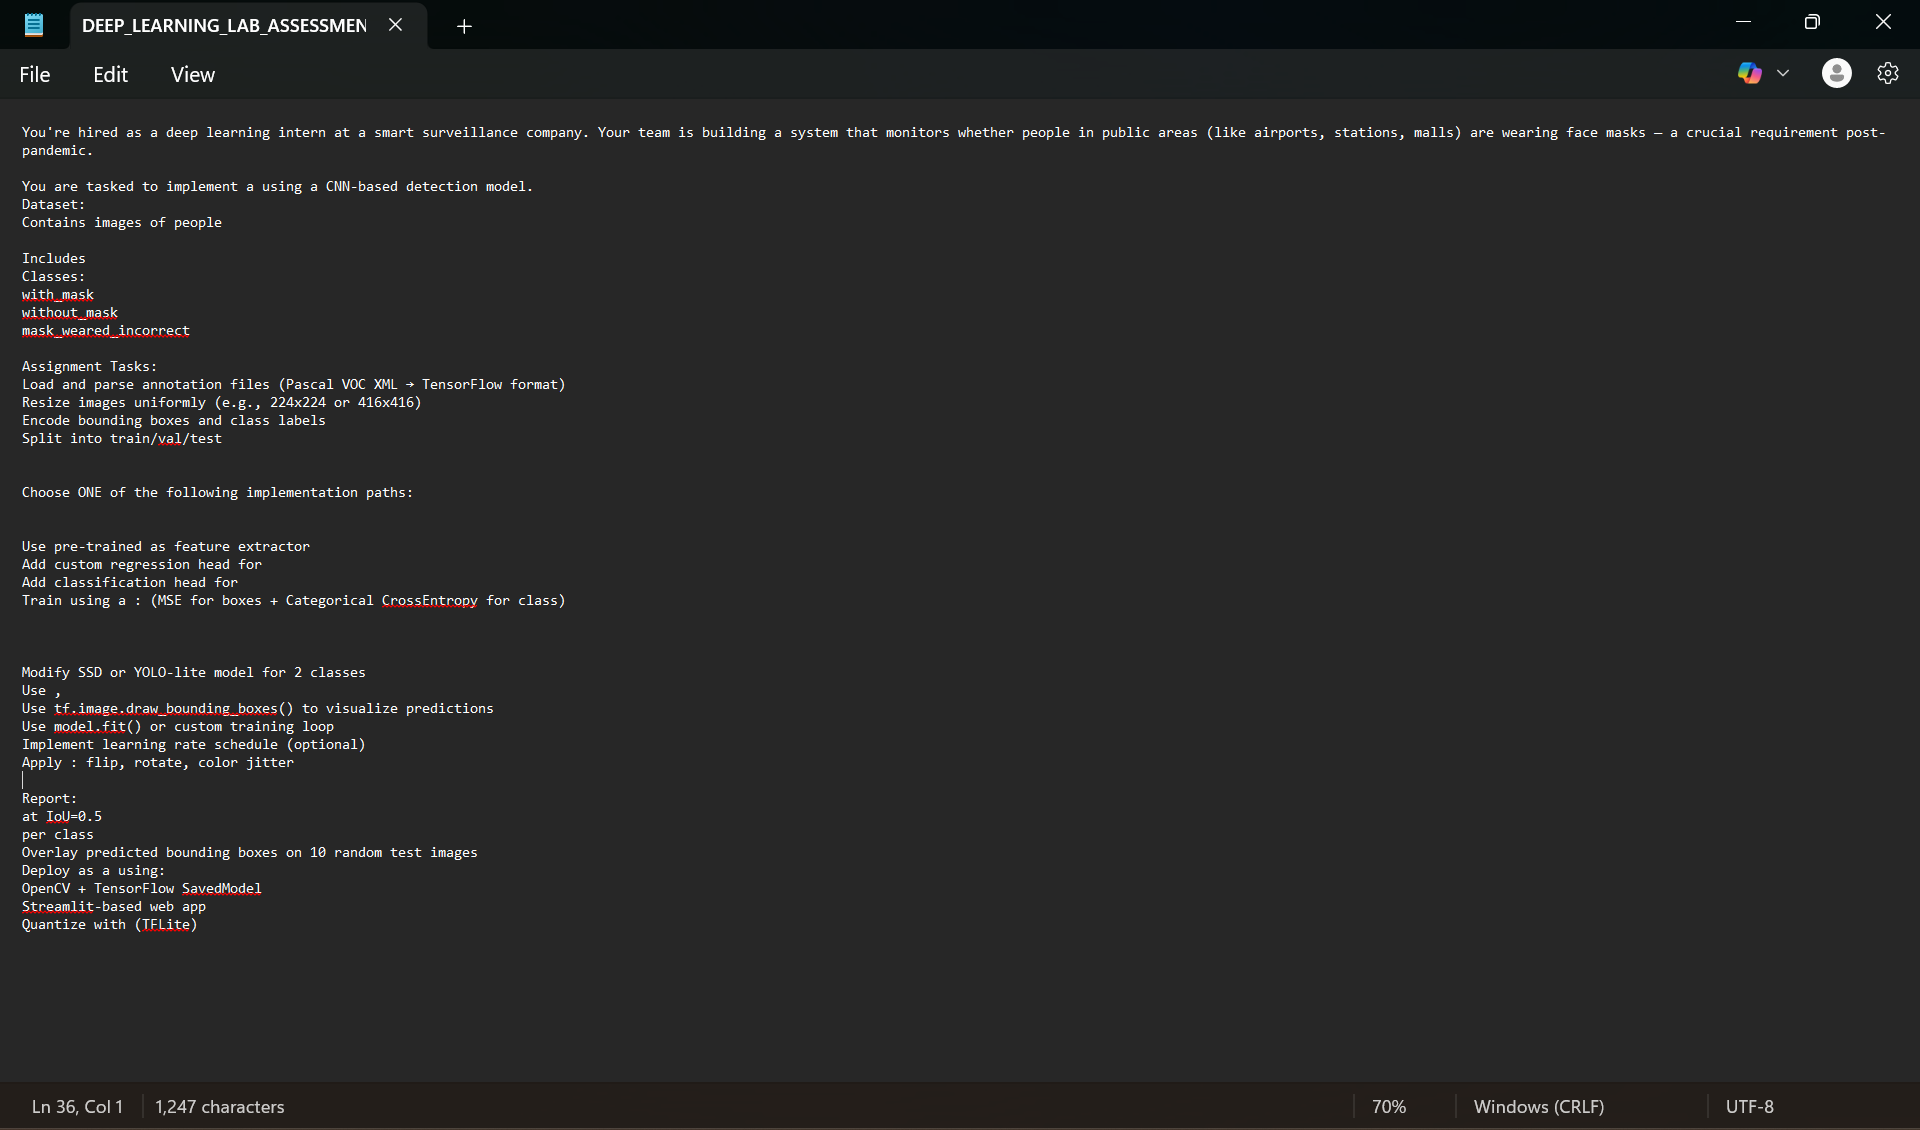

## Step 1: Imports & Path Setup

In [37]:
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

ANNOT_DIR = r'C:\Users\Gurunath Chavan\Desktop\CDAC\ASSIGNMENTS\DEEP LEARNING\LAB_ASSESSMENT\data\annotations'
IMAGE_DIR = r'C:\Users\Gurunath Chavan\Desktop\CDAC\ASSIGNMENTS\DEEP LEARNING\LAB_ASSESSMENT\data\images'
OUT_DIR = r'C:\Users\Gurunath Chavan\Desktop\CDAC\ASSIGNMENTS\DEEP LEARNING\LAB_ASSESSMENT\data'

## Step 2: Parse Annotations and Create Splits

In [19]:
CLASS_MAP = {'with_mask': 0, 'without_mask': 1, 'mask_worn_incorrect': 2}
records = []

for xml_file in os.listdir(ANNOT_DIR):
    if not xml_file.endswith('.xml'):
        continue
    tree = ET.parse(os.path.join(ANNOT_DIR, xml_file))
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall('object'):
        cls = obj.find('name').text
        cls_id = CLASS_MAP.get(cls, -1)
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        records.append([filename, cls_id, xmin, ymin, xmax, ymax])

df = pd.DataFrame(records, columns=['filename', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
imgs = df['filename'].unique()
train_imgs, test_imgs = train_test_split(imgs, test_size=0.15, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.1765, random_state=42)

df['split'] = df['filename'].map(lambda x: 'test' if x in test_imgs else ('val' if x in val_imgs else 'train'))

df[df['split'] == 'train'].to_csv(os.path.join(OUT_DIR, 'train.csv'), index=False)
df[df['split'] == 'val'].to_csv(os.path.join(OUT_DIR, 'val.csv'), index=False)
df[df['split'] == 'test'].to_csv(os.path.join(OUT_DIR, 'test.csv'), index=False)

print('Train:', len(df[df["split"] == "train"]["filename"].unique()))
print('Val:', len(df[df["split"] == "val"]["filename"].unique()))
print('Test:', len(df[df["split"] == "test"]["filename"].unique()))

Train: 597
Val: 128
Test: 128


## Step 3: Dataset Loader

In [34]:
# Step 3: Dataset Loader with Augmentation

IMG_SIZE = 224
NUM_CLASSES = 3

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)
plain_datagen = ImageDataGenerator()

def parse_row(row, image_dir):
    img_path = os.path.join(image_dir, row['filename'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    h, w, _ = image.shape
    bbox = np.array([
        row['xmin']/w, row['ymin']/h, row['xmax']/w, row['ymax']/h
    ], dtype=np.float32)
    label = tf.keras.utils.to_categorical(row['class_id'], NUM_CLASSES)
    return image, bbox, label

def load_dataset(csv_path, image_dir, augment=False):
    df = pd.read_csv(csv_path)
    data = [parse_row(row, image_dir) for _, row in df.iterrows()]
    images, bboxes, labels = zip(*data)
    images = np.array(images)
    bboxes = np.array(bboxes)
    labels = np.array(labels)
    if augment:
        aug_images = []
        for img in images:
            img = train_datagen.random_transform(img)
            aug_images.append(img)
        images = np.array(aug_images)
    return images, bboxes, labels

## Step 4: Load Data for Training and Validation

In [35]:
train_images, train_bboxes, train_labels = load_dataset(
    os.path.join(OUT_DIR, 'train.csv'), IMAGE_DIR, augment=True
)
val_images, val_bboxes, val_labels = load_dataset(
    os.path.join(OUT_DIR, 'val.csv'), IMAGE_DIR
)
print("Train images:", train_images.shape)
print("Val images:", val_images.shape)

Train images: (2904, 224, 224, 3)
Val images: (581, 224, 224, 3)


## Step 5: Model Definition

In [38]:
def build_detector(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    bbox = Dense(4, activation='sigmoid', name='bbox')(x)
    label = Dense(num_classes, activation='softmax', name='class')(x)
    model = Model(inputs=base.input, outputs=[bbox, label])
    return model

model = build_detector()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'bbox': 'mse', 'class': 'categorical_crossentropy'},
    metrics={'bbox': 'mse', 'class': 'accuracy'}
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 2,232,839 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Step 6: Train the Model

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    x=train_images, 
    y={'bbox': train_bboxes, 'class': train_labels},
    validation_data=(val_images, {'bbox': val_bboxes, 'class': val_labels}),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 152s 702ms/step - bbox_loss: 0.2159 - bbox_mse: 0.2159 - class_accuracy: 0.7077 - class_loss: 0.7329 - loss: 0.9488 - val_bbox_loss: 0.1620 - val_bbox_mse: 0.1624 - val_class_accuracy: 0.6179 - val_class_loss: 0.9718 - val_loss: 1.1435 - learning_rate: 1.0000e-04
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 125s 686ms/step - bbox_loss: 0.1490 - bbox_mse: 0.1490 - class_accuracy: 0.8460 - class_loss: 0.3972 - loss: 0.5462 - val_bbox_loss: 0.1586 - val_bbox_mse: 0.1589 - val_class_accuracy: 0.7504 - val_class_loss: 0.9800 - val_loss: 1.1408 - learning_rate: 1.0000e-04
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 127s 696ms/step - bbox_loss: 0.1383 - bbox_mse: 0.1383 - class_accuracy: 0.8675 - class_loss: 0.3376 - loss: 0.4759 - val_bbox_loss: 0.1371 - val_bbox_mse: 0.1376 - val_class_accuracy: 0.7470 - val_class_loss: 0.9253 - val_loss: 1.0607 - learning_rate: 1.0000e-04
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 124s 682ms/step - bbox_loss: 0.1423 - bbox_mse: 

In [40]:
model.save(os.path.join(OUT_DIR, 'mask_detector_model.keras'))

## Step 7: Evaluate and Visualize Predictions

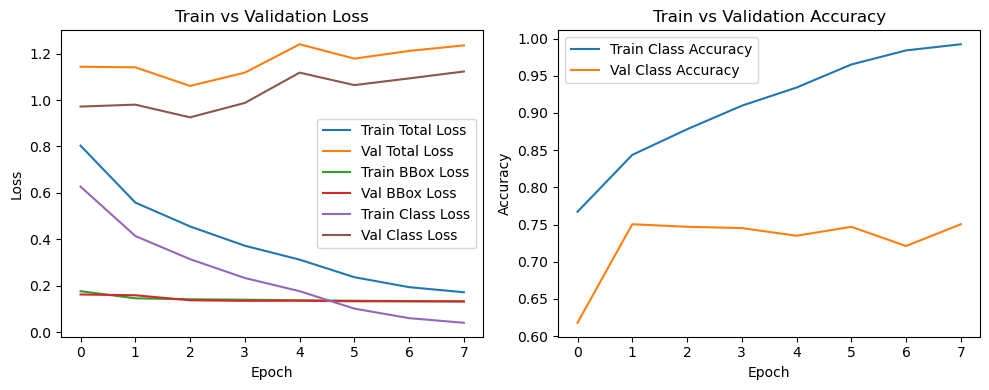

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.plot(history.history['bbox_loss'], label='Train BBox Loss')
plt.plot(history.history['val_bbox_loss'], label='Val BBox Loss')
plt.plot(history.history['class_loss'], label='Train Class Loss')
plt.plot(history.history['val_class_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['class_accuracy'], label='Train Class Accuracy')
plt.plot(history.history['val_class_accuracy'], label='Val Class Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
test_images, test_bboxes, test_labels = load_dataset(
    os.path.join(OUT_DIR, 'test.csv'), IMAGE_DIR
)
model = tf.keras.models.load_model(os.path.join(OUT_DIR, 'mask_detector_model.keras'))

pred_bboxes, pred_classes = model.predict(test_images)
pred_class_ids = np.argmax(pred_classes, axis=1)
true_class_ids = np.argmax(test_labels, axis=1)

class_names = ['with_mask', 'without_mask', 'mask_worn_incorrect']

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step


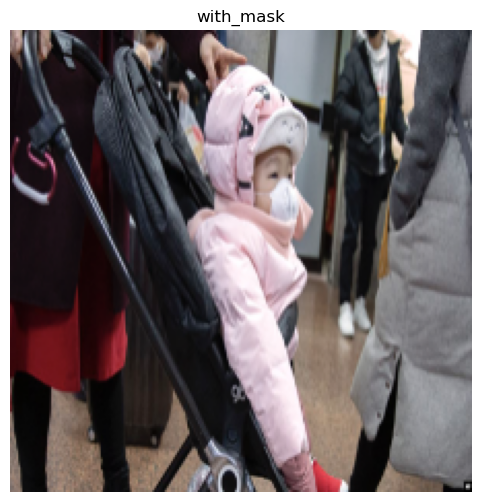

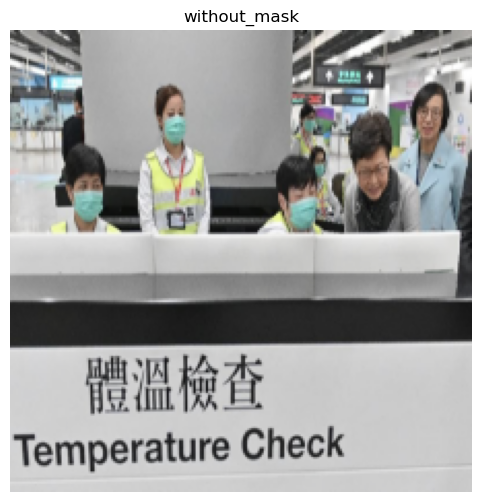

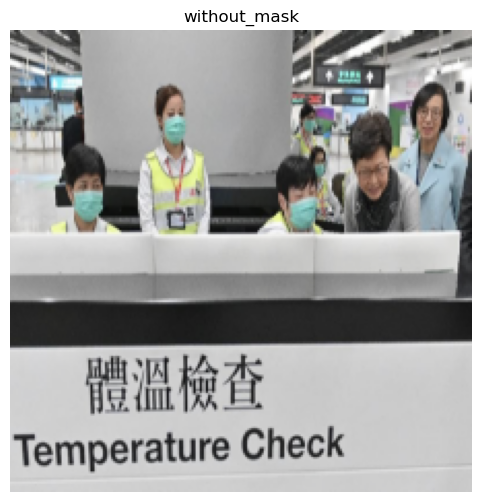

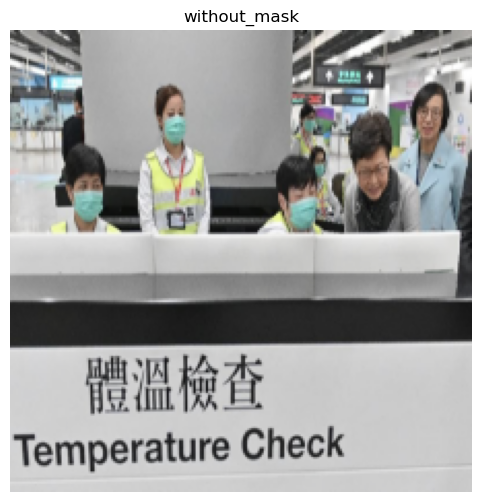

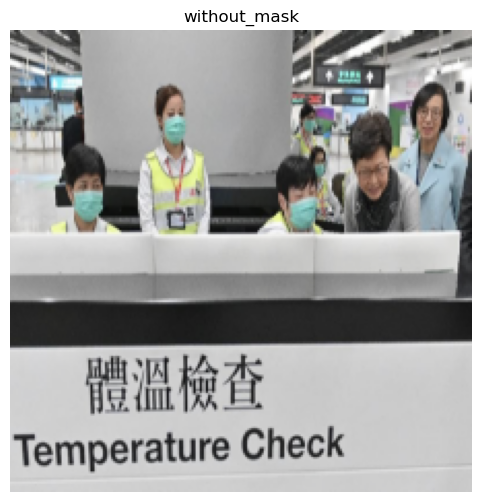

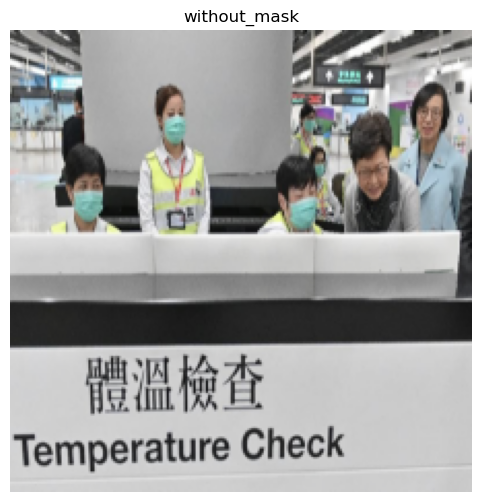

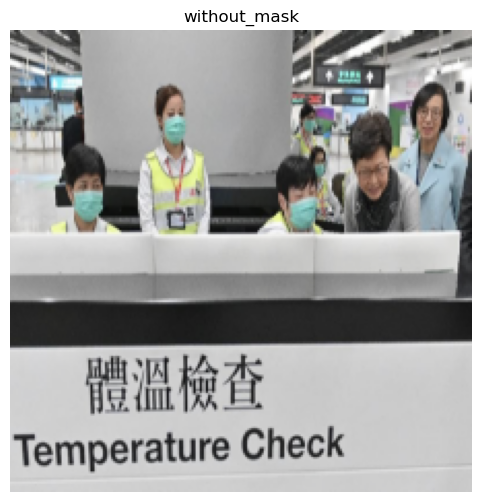

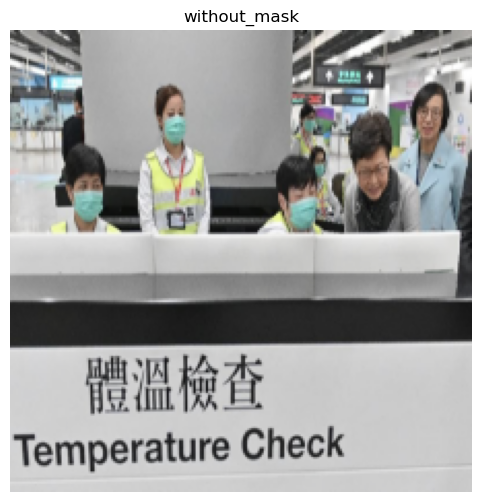

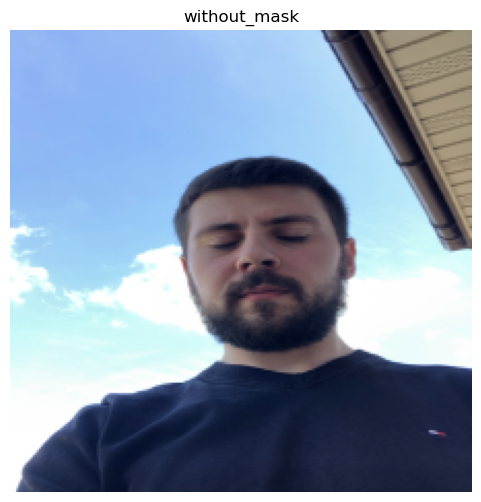

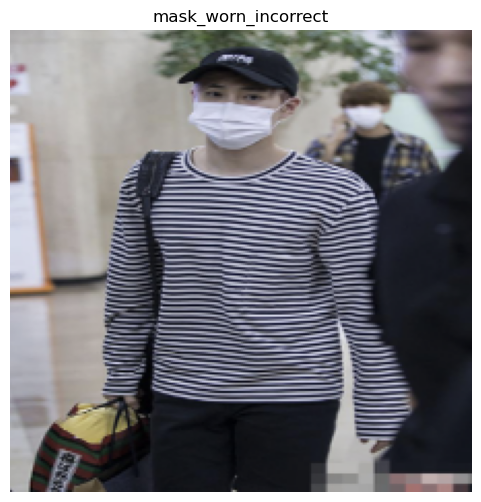

In [51]:
import matplotlib.pyplot as plt

for i in range(10):
    img = test_images[i].copy()
    pred_class = pred_class_ids[i]
    label = class_names[pred_class]
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()

## Step 8: Quantize Model for Edge Deployment

In [52]:
model = tf.keras.models.load_model(os.path.join(OUT_DIR, 'mask_detector_model.keras'))
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open(os.path.join(OUT_DIR, 'mask_detector_model.tflite'), 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved!")

INFO:tensorflow:Assets written to: C:\Users\GURUNA~1\AppData\Local\Temp\tmpwhd9l2s8\assets


INFO:tensorflow:Assets written to: C:\Users\GURUNA~1\AppData\Local\Temp\tmpwhd9l2s8\assets


Saved artifact at 'C:\Users\GURUNA~1\AppData\Local\Temp\tmpwhd9l2s8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  2347442485392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442476752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442474640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442476560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442475600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442477328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442472336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442476368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2347442477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23474

## Step 9 : Stream lit execution

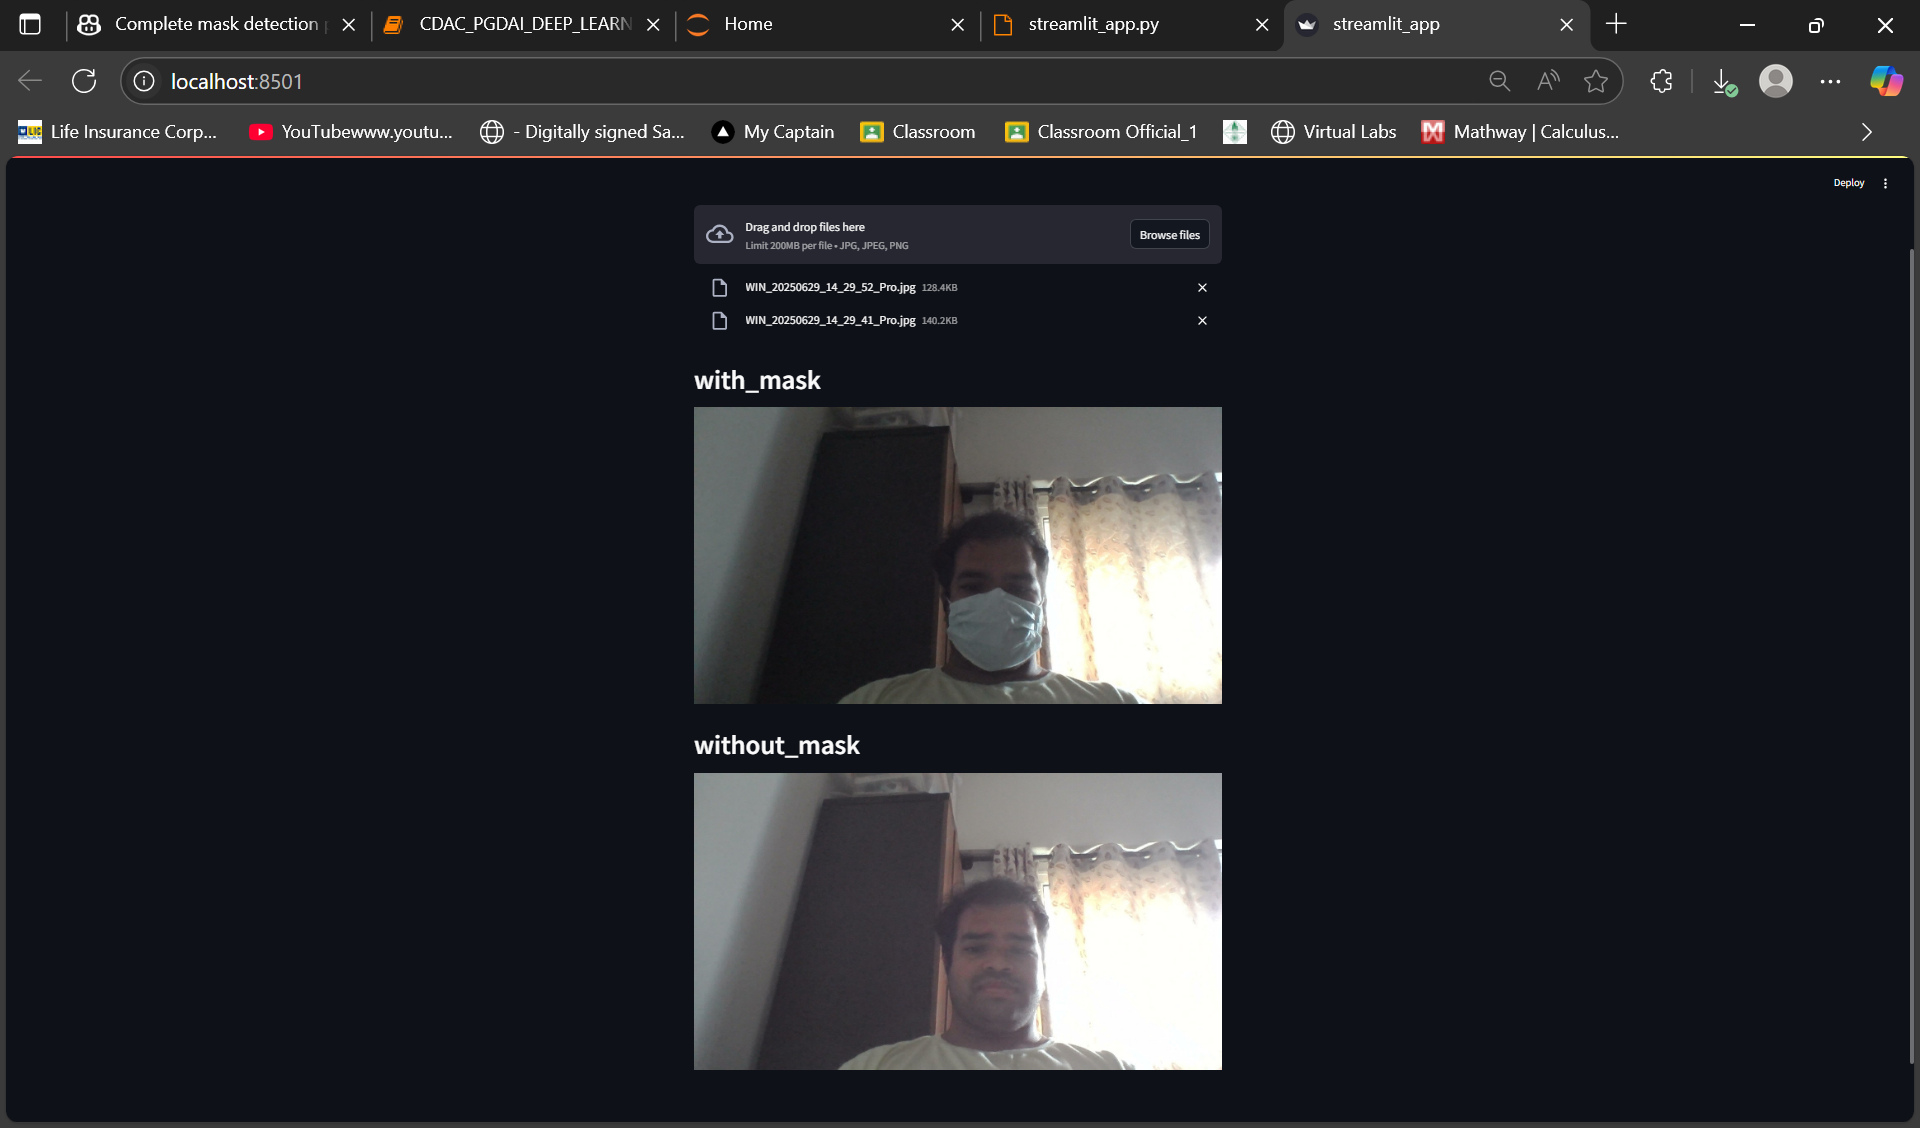